In [1]:
# Install necessary libraries
!pip install ultralytics opencv-python matplotlib numpy pandas albumentations gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [8]:
# Import Libraries
from ultralytics import YOLO
import os
import cv2
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load YOLOv8 Model
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 173MB/s]


In [5]:
images_dir = '/content/drive/MyDrive/datasets/vehicles/train/images'
labels_dir = '/content/drive/MyDrive/datasets/vehicles/train/labels'

images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
labels = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

Number of images: 2864
Number of labels: 2864


In [9]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.7),
    A.GaussianBlur(p=0.3),
    A.RGBShift(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

def augment_image(image_path, label_path, images_dir, labels_dir):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    h, w, _ = image.shape

    with open(label_path, 'r') as file:
        annotations = [line.strip().split() for line in file.readlines()]

    # Convert YOLO format to normalized format for Albumentations
    bboxes = []
    category_ids = []
    for ann in annotations:
        class_id, x, y, bw, bh = map(float, ann)
        bboxes.append([x, y, bw, bh])
        category_ids.append(int(class_id))

    # Apply Augmentation
    augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)

    # Save the Augmented Image
    aug_filename = f"aug_{os.path.basename(image_path)}"
    output_image_path = os.path.join(images_dir, aug_filename)
    cv2.imwrite(output_image_path, augmented['image'])

    # Save the Updated Annotations
    aug_label_filename = f"aug_{os.path.basename(label_path)}"
    output_label_path = os.path.join(labels_dir, aug_label_filename)
    with open(output_label_path, 'w') as file:
        for bbox, class_id in zip(augmented['bboxes'], augmented['category_ids']):
            file.write(f"{class_id} {' '.join(map(str, bbox))}\n")

    print(f"Augmented Image & Labels Saved: {output_image_path}")

    # Apply Augmentation to All Images in the Dataset
    images = glob.glob(f"{images_dir}/*.jpg")
    for img_path in images:
        label_path = os.path.join(labels_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')

        if os.path.exists(label_path):
            augment_image(img_path, label_path, images_dir, labels_dir)

    print("✅ Data augmentation complete for all images!")

In [10]:
# Function to Load a Random Image with Annotations
def load_random_sample(folder_path):
    """
    Randomly selects an image and its corresponding label from the dataset folder,
    then visualizes the image with bounding boxes and class labels.
    """
    image_folder = os.path.join(folder_path, "images")
    label_folder = os.path.join(folder_path, "labels")

    # Randomly select an image file
    image_file = random.choice(os.listdir(image_folder))
    label_file = os.path.splitext(image_file)[0] + '.txt'

    # Load image
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load label
    label_path = os.path.join(label_folder, label_file)
    h, w, _ = image.shape
    with open(label_path, 'r') as file:
        for line in file:
            # Parse YOLO annotation
            class_id, x_center, y_center, box_width, box_height = map(float, line.split())

            # Convert YOLO format to pixel coordinates
            x_min = int((x_center - box_width / 2) * w)
            y_min = int((y_center - box_height / 2) * h)
            x_max = int((x_center + box_width / 2) * w)
            y_max = int((y_center + box_height / 2) * h)

            # Draw bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(image, f"Class {int(class_id)}", (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


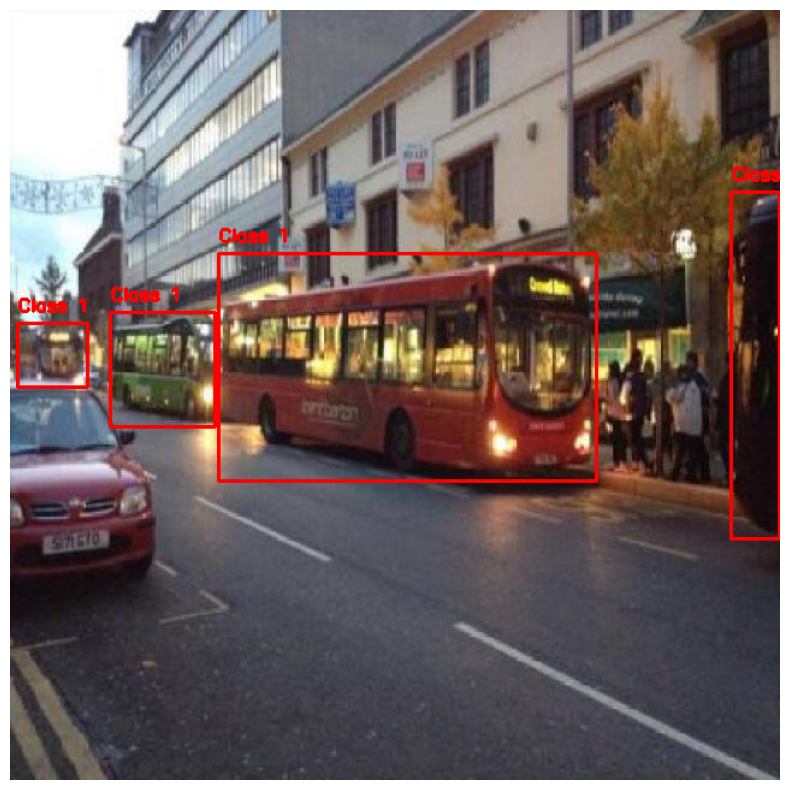

In [11]:
import random

# Example Usage
load_random_sample('/content/drive/MyDrive/datasets/vehicles/test')

In [12]:
# Detect Vehicles and Calculate Density
def detect_vehicles_and_calculate_density(image_path, confidence=0.5):
    """
    Detect vehicles in an image using YOLOv8 and calculate vehicle density.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # Run YOLOv8 inference
    results = model.predict(image, conf=confidence, save=False)

    # Define vehicle-related class names based on your dataset
    class_names = ['pedestrian', 'car', 'bike', 'bus', 'truck']  # Update if your dataset differs
    vehicle_classes = ['car', 'bike', 'bus', 'truck']  # Classes to consider as vehicles
    vehicle_class_ids = [class_names.index(cls) for cls in vehicle_classes]

    # Count vehicles in the detections
    vehicle_count = 0
    for result in results:
        for box in result.boxes:
            if int(box.cls) in vehicle_class_ids:
                vehicle_count += 1

    # Calculate vehicle density (example: vehicles per square meter)
    image_area = image.shape[0] * image.shape[1]  # Area in pixels
    vehicle_density = vehicle_count / image_area  # Density as vehicles per pixel

    # Display the vehicle count and density
    print(f"Number of vehicles detected: {vehicle_count}")
    print(f"Vehicle density: {vehicle_density:.6f} vehicles per pixel")

    # Visualize detections
    annotated_image = results[0].plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [13]:
!ls '/content/drive/MyDrive/datasets/vehicles/test/images/test04.jpg'

/content/drive/MyDrive/datasets/vehicles/test/images/test04.jpg



0: 480x640 15 cars, 2 trucks, 66.2ms
Speed: 8.2ms preprocess, 66.2ms inference, 413.6ms postprocess per image at shape (1, 3, 480, 640)
Number of vehicles detected: 15
Vehicle density: 0.000051 vehicles per pixel


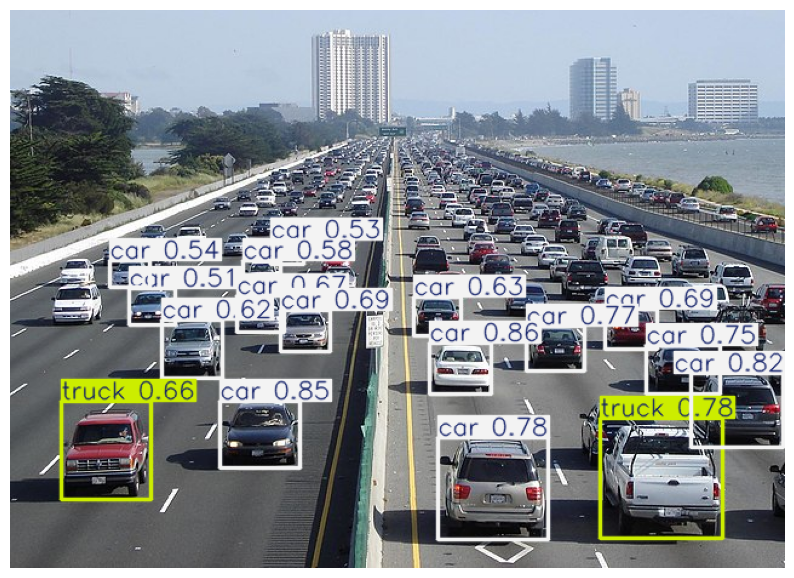

In [14]:
# Example Usage: Detect Vehicles and Calculate Density
test_image_path = '/content/drive/MyDrive/datasets/vehicles/test/images/test04.jpg'
detect_vehicles_and_calculate_density(test_image_path, confidence=0.5)

In [ ]:
# Train YOLOv8 Model
model.train(
    data='/content/drive/MyDrive/datasets/vehicles/data.yaml',  # Path to YAML file
    epochs=100,  # Number of training epochs
    batch=16,   # Batch size
    imgsz=640,  # Image size
    optimizer='AdamW',  # Optimizer choice
)
print("Training Completed!")

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/datasets/vehicles/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/datasets/vehicles/train/labels.cache... 2864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2864/2864 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/datasets/vehicles/valid/labels.cache... 236 images, 0 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.8G       1.46      2.159      1.741         48        640: 100%|██████████| 179/179 [11:37<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        236        342      0.199      0.224      0.124     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.58G      1.361      1.976      1.682         37        640: 100%|██████████| 179/179 [01:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


                   all        236        342      0.475      0.306      0.299      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.58G      1.345      1.978      1.675         47        640: 100%|██████████| 179/179 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]

                   all        236        342      0.524       0.24      0.222       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.58G      1.266      1.822      1.601         51        640: 100%|██████████| 179/179 [01:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


                   all        236        342      0.609      0.386       0.38      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.58G       1.23      1.702      1.565         41        640: 100%|██████████| 179/179 [01:11<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


                   all        236        342      0.518       0.45      0.429      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.58G      1.197      1.649      1.537         42        640: 100%|██████████| 179/179 [01:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        236        342      0.452      0.504      0.434      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.58G       1.15      1.556      1.492         60        640: 100%|██████████| 179/179 [01:10<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


                   all        236        342      0.717      0.501      0.533      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.58G      1.133      1.524      1.488         54        640: 100%|██████████| 179/179 [01:10<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all        236        342      0.562      0.504       0.52      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.58G      1.113      1.472      1.463         50        640: 100%|██████████| 179/179 [01:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        236        342      0.595       0.53      0.578      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.58G      1.085        1.4      1.443         49        640: 100%|██████████| 179/179 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        236        342      0.726      0.546      0.597      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.58G       1.06      1.362      1.428         46        640: 100%|██████████| 179/179 [01:10<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


                   all        236        342      0.579      0.568      0.549      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.58G      1.053      1.316      1.417         46        640: 100%|██████████| 179/179 [01:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        236        342      0.605      0.602      0.622      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.58G       1.02      1.261      1.386         43        640: 100%|██████████| 179/179 [01:10<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


                   all        236        342      0.608      0.601      0.623       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.58G      1.048      1.289      1.408         64        640: 100%|██████████| 179/179 [01:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


                   all        236        342      0.713      0.557      0.626      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.58G      0.982      1.182      1.363         50        640: 100%|██████████| 179/179 [01:10<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        236        342      0.656      0.642       0.67      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.58G     0.9925      1.188      1.373         58        640: 100%|██████████| 179/179 [01:11<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        236        342       0.67      0.608      0.645       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.58G     0.9785      1.146      1.361         55        640: 100%|██████████| 179/179 [01:10<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        236        342      0.673      0.613      0.639      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.58G     0.9487      1.117      1.342         56        640: 100%|██████████| 179/179 [01:11<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        236        342      0.672       0.59      0.618      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.58G     0.9353      1.103      1.321         70        640: 100%|██████████| 179/179 [01:10<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

                   all        236        342      0.698      0.584      0.648      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.58G     0.9231      1.061      1.317         44        640: 100%|██████████| 179/179 [01:10<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

                   all        236        342      0.725      0.635      0.684      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.58G     0.9115      1.052      1.315         55        640: 100%|██████████| 179/179 [01:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        236        342      0.593      0.658      0.642      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.58G     0.9123      1.017      1.306         46        640: 100%|██████████| 179/179 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

                   all        236        342      0.642      0.569      0.609      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.58G     0.9075      1.015      1.303         54        640: 100%|██████████| 179/179 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all        236        342       0.71      0.639      0.676      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.58G     0.8856     0.9781      1.291         53        640:  79%|███████▉  | 142/179 [00:55<00:12,  2.98it/s]


image 1/1 /content/drive/MyDrive/datasets/vehicles/test/images/sample2.jpg: 448x640 10 cars, 52.0ms
Speed: 2.6ms preprocess, 52.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Number of vehicles detected: 10
Vehicle density: 0.000051 vehicles per pixel


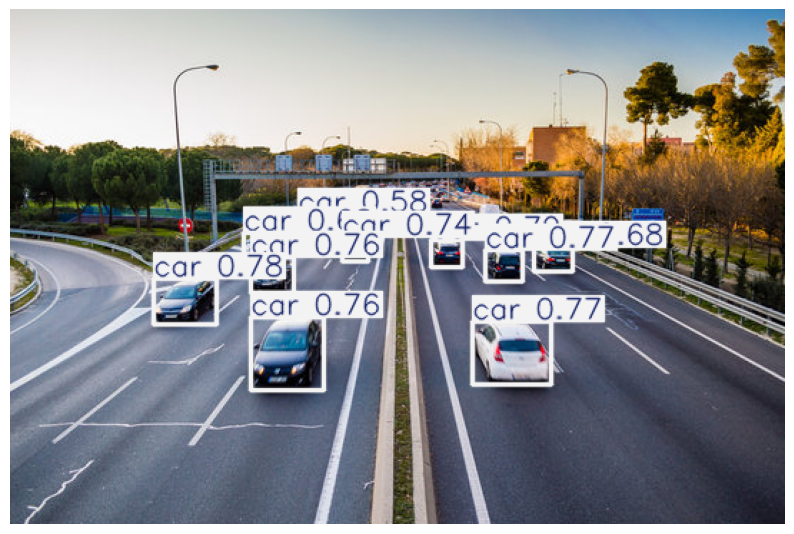

In [ ]:
# Perform inference with YOLOv8 on a sample image
sample_image = '/content/drive/MyDrive/datasets/vehicles/test/images/sample2.jpg'
results = model.predict(sample_image, conf=0.5)

# Load class names (adjust this based on your dataset's YAML file)
class_names = ['Ambulance', 'Bus', 'Motorcycle', 'Truck', 'Vehicle']
vehicle_classes = ['Ambulance', 'Bus', 'Motorcycle', 'Truck', 'Vehicle']  # Classes considered as vehicles
vehicle_class_ids = [class_names.index(cls) for cls in vehicle_classes]

# Count vehicles in the detections
vehicle_count = 0
for result in results:
    for box in result.boxes:
        if int(box.cls) in vehicle_class_ids:
            vehicle_count += 1

# Calculate vehicle density
image = cv2.imread(sample_image)
height, width, _ = image.shape
image_area = height * width  # Total image area in pixels
vehicle_density = vehicle_count / image_area  # Vehicles per pixel

# Display the vehicle count and vehicle density
print(f"Number of vehicles detected: {vehicle_count}")
print(f"Vehicle density: {vehicle_density:.6f} vehicles per pixel")

# Visualize detections
annotated_image = results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



0: 448x640 10 cars, 11.0ms
Speed: 4.7ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Number of vehicles detected: 10
Vehicle density: 0.000051 vehicles per pixel


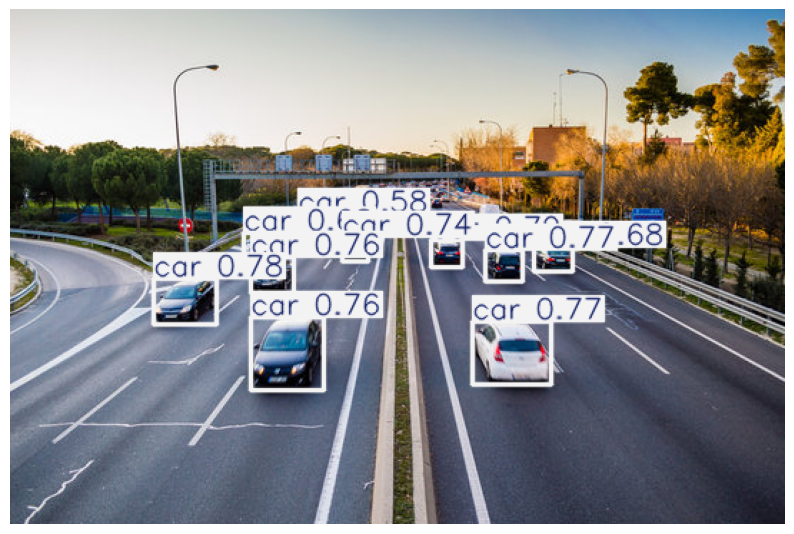

In [ ]:
# Path to a test image (replace with your image path)
test_image_path = '/content/drive/MyDrive/datasets/vehicles/test/images/sample2.jpg'

# Visualize the test image and calculate vehicle density
detect_vehicles_and_calculate_density(test_image_path, confidence=0.5)


In [ ]:
# Perform Validation on the Test Set
results = model.val(data='/content/drive/MyDrive/datasets/vehicles/data.yaml', split='test')

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/datasets/vehicles/test/labels... 119 images, 3 backgrounds, 0 corrupt: 100%|██████████| 122/122 [01:35<00:00,  1.28it/s]

val: New cache created: /content/drive/MyDrive/datasets/vehicles/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


                   all        122        186      0.853      0.678      0.735      0.567
             Ambulance         19         19      0.954          1      0.995      0.862
                   Bus         32         40      0.972      0.866      0.892      0.693
            Motorcycle          6         16      0.798      0.248      0.356      0.194
                 Truck         21         24      0.887      0.792      0.872      0.697
               Vehicle         41         87      0.652      0.483      0.557      0.387
Speed: 5.3ms preprocess, 9.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/train22


In [ ]:
# Extract and Convert Metrics to Percentages
precision = results.results_dict['metrics/precision(B)'] * 100
recall = results.results_dict['metrics/recall(B)'] * 100
map50 = results.results_dict['metrics/mAP50(B)'] * 100
map50_95 = results.results_dict['metrics/mAP50-95(B)'] * 100

# Print the Metrics
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"mAP@50: {map50:.2f}%")
print(f"mAP@50-95: {map50_95:.2f}%")

Precision: 85.26%
Recall: 67.77%
mAP@50: 73.46%
mAP@50-95: 56.66%


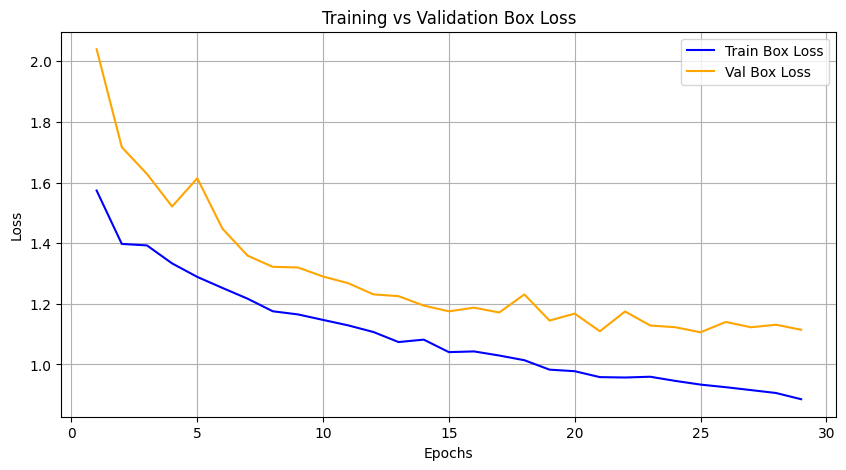

In [ ]:
# Plot Training vs Validation Box Loss
results_dir = '/content/runs/detect/train'
metrics_file = os.path.join(results_dir, 'results.csv')

if os.path.exists(metrics_file):
    df = pd.read_csv(metrics_file)
    if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
        plt.title("Training vs Validation Box Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Box loss data not found in the results file!")
else:
    print("Results file not found! Ensure training completed successfully.")